# Setting up

In [6]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [7]:
%cd /content/drive/MyDrive/Projects/1. Churn Prediction/

/content/drive/MyDrive/Projects/1. Churn Prediction


# Importing dataset

In [8]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

In [9]:
DATASET = "Trial 2: output_cleaned_dataset.csv"

In [10]:
df = pd.read_csv(DATASET)

In [11]:
df.shape

(6589, 41)

In [12]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
0,0.0,42.39,16.0,593.30,974.81,4498.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,0.0,10.69,10.0,542.40,610.28,31297.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0.0,33.65,30.0,280.85,415.45,62069.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
3,0.0,27.82,4.0,1237.85,1599.51,46677.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
4,0.0,7.38,11.0,267.40,289.54,42853.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0


# Cleaning dataset

## Splitting dataset into X and y

In [13]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [14]:
X.shape

(6589, 40)

In [15]:
y.shape

(6589,)

## Splitting dataset into train, test and val

In [16]:
# splitting into train (60%), test (20%) and val (20%)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, shuffle=True)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, shuffle=True)

In [17]:
X_train.shape

(3953, 40)

In [18]:
y_train.shape

(3953,)

In [19]:
X_test.shape

(1318, 40)

In [20]:
y_test.shape

(1318,)

In [21]:
X_val.shape

(1318, 40)

In [22]:
y_val.shape

(1318,)

# Testing out scalers

In [23]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

standard_scaler_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("classifier", RandomForestClassifier())
])

minmax_scaler_pipeline = Pipeline([
    ("scaler", MinMaxScaler()),
    ("classifier", RandomForestClassifier())
])

normalizer_pipeline = Pipeline([
    ("scaler", Normalizer()),
    ("classifier", RandomForestClassifier())
])

In [24]:
n = 1

In [25]:
# standard scaler baseline model
accs = []
for i in range(n):
  standard_scaler_model = standard_scaler_pipeline.fit(X_train, y_train)
  y_pred = standard_scaler_model.predict(X_test)
  accs.append(accuracy_score(y_test, y_pred))
sum(accs) / len(accs)

0.849772382397572

In [26]:
# minmax scaler baseline model
accs = []
for i in range(n):
  minmax_scaler_model = minmax_scaler_pipeline.fit(X_train, y_train)
  y_pred = minmax_scaler_model.predict(X_test)
  accs.append(accuracy_score(y_test, y_pred))
sum(accs) / len(accs)

0.849772382397572

In [27]:
# normalizer baseline model
accs = []
for i in range(n):
  normalizer_model = normalizer_pipeline.fit(X_train, y_train)
  y_pred = normalizer_model.predict(X_test)
  accs.append(accuracy_score(y_test, y_pred))
sum(accs) / len(accs)

0.8406676783004552

All 3 scalers seem to be producing more or less the same results. I will choose Standard scaler for this use case.

In [28]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [29]:
X_train.shape

(3953, 40)

In [30]:
y_train.shape

(3953,)

In [31]:
X_test.shape

(1318, 40)

In [32]:
y_test.shape

(1318,)

# Training

## Building model

In [33]:
X_train[0].shape

(40,)

In [34]:
# building the model

import tensorflow
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.models import Sequential

model = Sequential(layers=[
    Dense(60, activation="relu", input_shape=(40,)),
    BatchNormalization(),
    Dense(60, activation="relu"),
    BatchNormalization(),
    Dense(120, activation="relu"),
    BatchNormalization(),
    Dense(120, activation="relu"),
    BatchNormalization(),
    Dense(20, activation="relu"),
    BatchNormalization(),
    Dense(1, activation="sigmoid")
])

## Compiling and saving

In [35]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [36]:
checkpointer = tensorflow.keras.callbacks.ModelCheckpoint(
    "Trial 2: model1_weights.hdf5", 
    monitor="val_loss", 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=True
)

earlystopping = tensorflow.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=50,
    verbose=1
)

In [37]:
with open("Trial 2: model1.json", "w") as json_file:
  json_file.write(model.to_json())

## Fitting

In [38]:
history = model.fit(
    X_train, 
    y_train, 
    batch_size=8, 
    validation_data=(X_val, y_val), 
    verbose=1,
    callbacks=[checkpointer, earlystopping],
    shuffle=True,
    epochs=200
)

Epoch 1/200
492/495 [============================>.] - ETA: 0s - loss: 0.5412 - accuracy: 0.7335
Epoch 1: val_loss improved from inf to 6200.45312, saving model to Trial 2: model1_weights.hdf5
495/495 [==============================] - 7s 7ms/step - loss: 0.5401 - accuracy: 0.7341 - val_loss: 6200.4531 - val_accuracy: 0.3649
Epoch 2/200
490/495 [============================>.] - ETA: 0s - loss: 0.4412 - accuracy: 0.7888
Epoch 2: val_loss improved from 6200.45312 to 1602.96545, saving model to Trial 2: model1_weights.hdf5
495/495 [==============================] - 4s 8ms/step - loss: 0.4425 - accuracy: 0.7883 - val_loss: 1602.9655 - val_accuracy: 0.4006
Epoch 3/200
491/495 [============================>.] - ETA: 0s - loss: 0.4201 - accuracy: 0.8037
Epoch 3: val_loss improved from 1602.96545 to 530.54651, saving model to Trial 2: model1_weights.hdf5
495/495 [==============================] - 2s 4ms/step - loss: 0.4198 - accuracy: 0.8037 - val_loss: 530.5465 - val_accuracy: 0.7185
Epoch 4

# Analysing

In [39]:
training_acc = history.history["accuracy"]
training_loss = history.history["loss"]
val_acc = history.history["val_accuracy"]
val_loss = history.history["val_loss"]

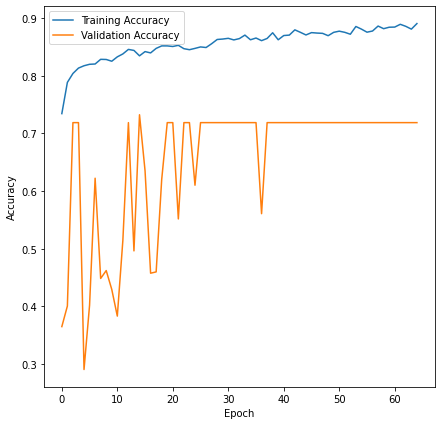

In [40]:
plt.figure(figsize=(7, 7))
plt.plot(history.epoch, training_acc, label="Training Accuracy")
plt.plot(history.epoch, val_acc, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

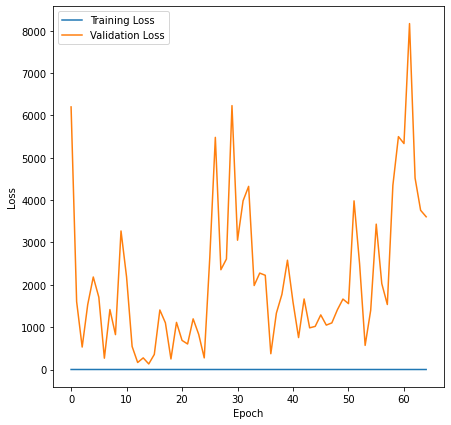

In [41]:
plt.figure(figsize=(7, 7))
plt.plot(history.epoch, training_loss, label="Training Loss")
plt.plot(history.epoch, val_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [42]:
y_pred = np.round(model.predict(X_test))

42/42 [==============================] - 0s 2ms/step


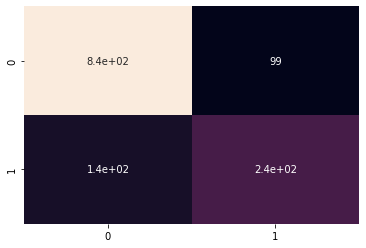

In [43]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, precision_score, recall_score

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cbar=False)
plt.show()

In [44]:
accuracy_score(y_test, y_pred)

0.8148710166919575

In [45]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.85      0.89      0.87       938
         1.0       0.70      0.62      0.66       380

    accuracy                           0.81      1318
   macro avg       0.78      0.76      0.77      1318
weighted avg       0.81      0.81      0.81      1318



In [46]:
stayed_precision = precision_score(y_test, y_pred, labels=[0, 1], pos_label=0)

In [47]:
churned_precision = precision_score(y_test, y_pred, labels=[0, 1], pos_label=1)

In [48]:
stayed_recall = recall_score(y_test, y_pred, labels=[0, 1], pos_label=0)

In [49]:
churned_recall = recall_score(y_test, y_pred, labels=[0, 1], pos_label=1)

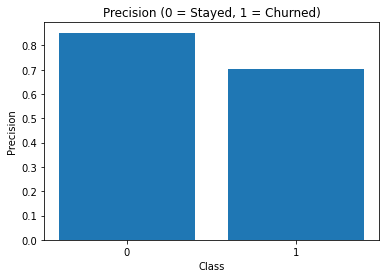

In [50]:
plt.bar(["0", "1"], [stayed_precision, churned_precision])
plt.xlabel("Class")
plt.ylabel("Precision")
plt.title("Precision (0 = Stayed, 1 = Churned)")
plt.show()

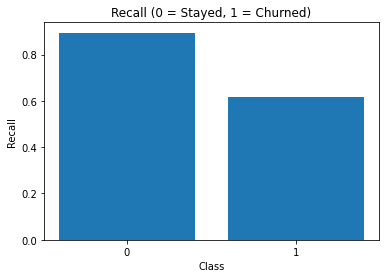

In [51]:
plt.bar(["0", "1"], [stayed_recall, churned_recall])
plt.xlabel("Class")
plt.ylabel("Recall")
plt.title("Recall (0 = Stayed, 1 = Churned)")
plt.show()